In [3]:
import pandas as pd
from molskill.scorer import MolSkillScorer
import seaborn as sns
from rdkit import Chem
from rdkit.Chem.QED import qed
from rdkit.Chem import RDConfig
import os
import sys
# Add to PYTHON_PATH to use SAScore
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
import scikit_posthocs as sp
import mols2grid

Read the input data
- chembl_drugs.smi - drugs from the ChEMBL database
- chembl_sample.smi - random molecules from ChEMBL
- odd_mols.smi - weird molecules produced by a generative algorithm
- reos_fail_mols.smi - molecules that failed functional group filters

In [4]:
file_list = ['chembl_drugs.smi','chembl_sample.smi','odd_mols.smi','reos_fail_mols.smi']
name_list = ['Drugs','ChEMBL','Odd',"REOS"]

Read the input SMILES files and combine the data into one dataframe

In [5]:
df_list = []
for filename,dataset in zip(file_list, name_list):
    df = pd.read_csv(filename)
    df['Dataset'] = dataset
    df_list.append(df)
combo_df = pd.concat(df_list)

A quick check to see how many molecules we have from each dataset

In [6]:
combo_df.Dataset.value_counts()

ChEMBL    2000
Odd       2000
REOS      2000
Drugs     1935
Name: Dataset, dtype: int64

Display some of the molecules from the "Odd" set, very scary. 

In [7]:
tmp_df = combo_df.query("Dataset == 'Odd'").copy()
tmp_df['len'] = [len(x) for x in tmp_df.SMILES]
mols2grid.display(tmp_df.query("len > 10").sort_values('len'),subset=["img"],selection=False)

Calculate the MolSkill score

In [8]:
scorer = MolSkillScorer()
combo_df['skill_score'] = scorer.score(combo_df.SMILES.values)

[2023-03-29 20:32:16,741] [INFO] [scorer.py:51:__init__] Model not specified. Using default from /home/pwalters/anaconda3/envs/rdkit_2022_03/lib/python3.9/site-packages/models/default/checkpoints/last.ckpt.


Lightning automatically upgraded your loaded checkpoint from v1.6.3 to v1.9.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../anaconda3/envs/rdkit_2022_03/lib/python3.9/site-packages/models/default/checkpoints/last.ckpt`
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2023-03-29 20:32:20.030245: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Predicting: 0it [00:00, ?it/s]

Define a function to calculate QED

In [9]:
def calc_qed(smi):
    mol = Chem.MolFromSmiles(smi)
    res = None
    if mol:
        res = qed(mol)
    return res

Add a QED column to **combo_df**

In [10]:
combo_df['qed'] = combo_df.SMILES.apply(calc_qed)

View **combo_df**

In [11]:
combo_df

,SMILES,Dataset,skill_score,qed
0,Br.CC(N)Cc1ccc(O)cc1,Drugs,-3.858946,0.816968
1,Br.CC(NC(C)(C)C)C(=O)c1cccc(Cl)c1,Drugs,-19.767942,0.856450
2,Br.CC1C2Cc3ccc(O)cc3C1(C)CCN2CCc1ccccc1,Drugs,-4.344647,0.802067
3,Br.CCN(c1cc(-c2ccc(CN3CCOCC3)cc2)cc(C(=O)NCc2c...,Drugs,-0.819281,0.325783
4,Br.CN(C)CCCC1(c2ccc(F)cc2)OCc2cc(C#N)ccc21,Drugs,-12.753349,0.740501
...,...,...,...,...
1995,CN1CCN(CCCCCNc2cc3c4c(c(NCCCCCN5CCN(C)CC5)cc5c...,REOS,11.973133,0.101489
1996,O=P(O)(O)Cc1cc(CP(=O)(O)O)cc(-c2ccccc2)c1,REOS,14.373476,0.621201
1997,O=C(Nc1cccc(CN2CCCN(CCc3ccccc3)CC2)c1)c1cc2ccc...,REOS,-9.192528,0.258684
1998,c1ccc(CNC2C3N(Cc4ccccc4)C4C(N2Cc2ccccc2)N(Cc2c...,REOS,-0.724432,0.129677


In [12]:
combo_df.columns

Index(['SMILES', 'Dataset', 'skill_score', 'qed'], dtype='object')

It doesn't look like QED and Skill Score are correlated.

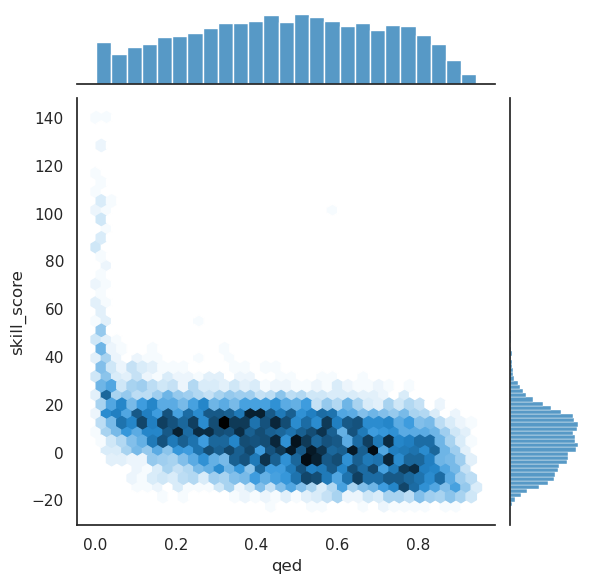

In [13]:
sns.set_style('white')
sns.set_context('notebook')
sns.jointplot(x="qed",y="skill_score",data=combo_df,kind="hex")

If we look at the Skill Score distributions for our four datasets, things look like we'd expect.  The ChEMBL and drug sets have lower scores than the REOS and Odd sets.  Since the Skill Score was trained on ChEMBL, it's not surprising that the ChEMBL molecules received the lowest scores. 

<Axes: xlabel='skill_score', ylabel='Density'>

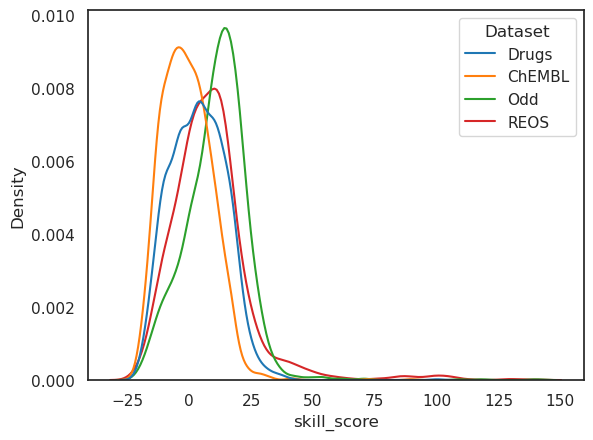

In [14]:
sns.kdeplot(x="skill_score",hue="Dataset",data=combo_df)

It's difficult to see the difference based on a KDE plot.  Let's try a boxplot variant. 

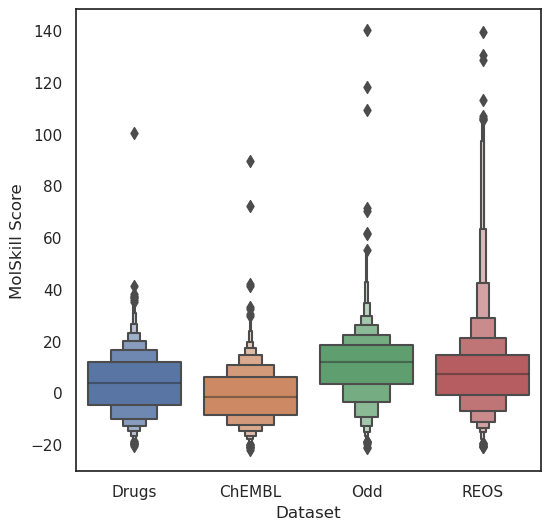

In [21]:
sns.set(rc={'figure.figsize':(6,6)})
sns.set_style('white')
sns.set_context('notebook')
ax = sns.boxenplot(x="Dataset",y="skill_score",data=combo_df)
ax.set_ylabel("MolSkill Score");

We can use scikit-posthocs to determine the significance of the differences between distributions. 

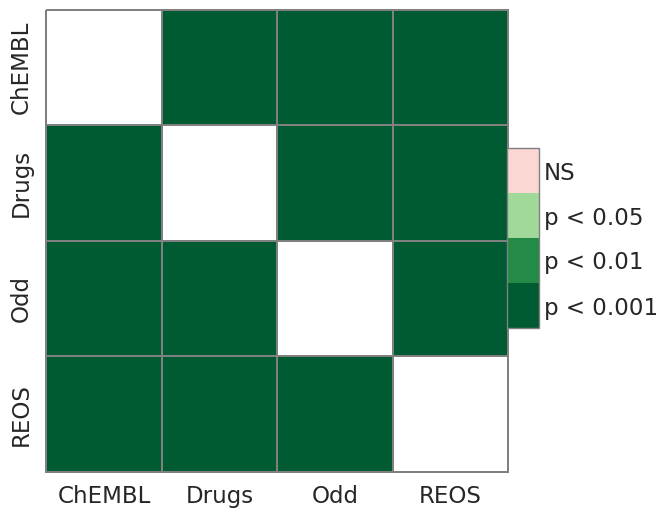

In [18]:
sns.set(rc={'figure.figsize':(8,6)},font_scale=1.5)
pc = sp.posthoc_mannwhitney(combo_df,val_col="skill_score",group_col="Dataset",p_adjust='holm')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
_ = sp.sign_plot(pc, **heatmap_args)

Let's do the same comparison with QED

Text(0, 0.5, 'QED')

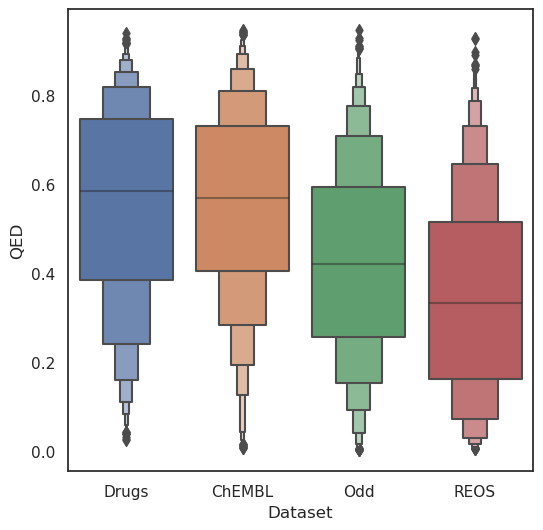

In [25]:
sns.set(rc={'figure.figsize':(6,6)})
sns.set_style('white')
sns.set_context('notebook')
ax = sns.boxenplot(x="Dataset",y="qed",data=combo_df)
ax.set_ylabel("QED")

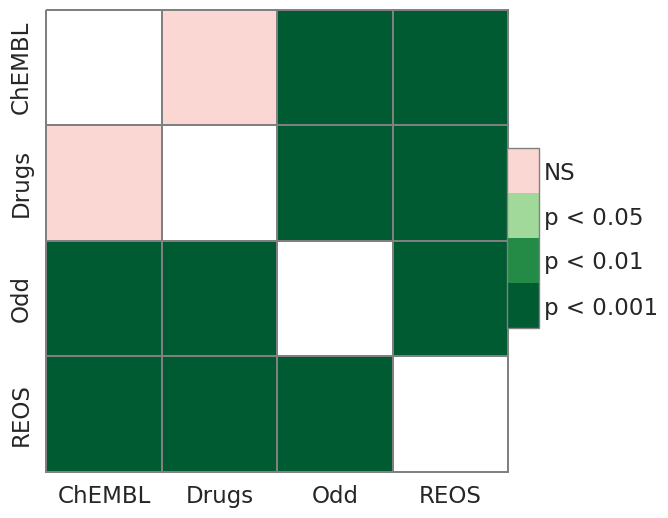

In [41]:
sns.set(rc={'figure.figsize':(8,6)},font_scale=1.5)
pc = sp.posthoc_mannwhitney(combo_df,val_col="qed",group_col="Dataset",p_adjust='holm')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
_ = sp.sign_plot(pc, **heatmap_args)

Define a function to calculate SA score.

In [26]:
def calc_sa_score(smi):
    mol = Chem.MolFromSmiles(smi)
    res = None
    if mol:
        res = sascorer.calculateScore(mol)
    return res

Add SA score to the dataframe.

In [27]:
combo_df['sa_score'] = combo_df.SMILES.apply(calc_sa_score)

Do the same exercise with SA score. 

Text(25.0, 0.5, 'SA Score')

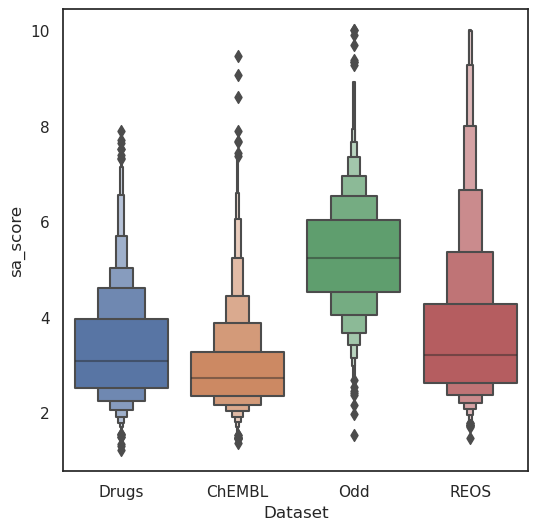

In [29]:
sns.set(rc={'figure.figsize':(6,6)})
sns.set_style('white')
sns.set_context('notebook')
sns.boxenplot(x="Dataset",y="sa_score",data=combo_df)
ax.set_ylabel("SA Score")

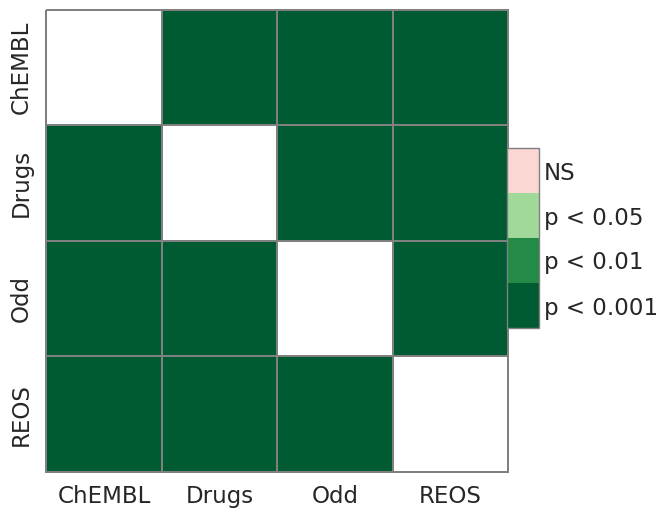

In [43]:
sns.set(rc={'figure.figsize':(8,6)},font_scale=1.5)
pc = sp.posthoc_mannwhitney(combo_df,val_col="sa_score",group_col="Dataset",p_adjust='holm')
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
_ = sp.sign_plot(pc, **heatmap_args)

Look at the dataframe

In [14]:
combo_df

,SMILES,Dataset,skill_score,qed,sa_score
0,Br.CC(N)Cc1ccc(O)cc1,Drugs,-3.858946,0.816968,2.343013
1,Br.CC(NC(C)(C)C)C(=O)c1cccc(Cl)c1,Drugs,-19.767942,0.856450,2.683098
2,Br.CC1C2Cc3ccc(O)cc3C1(C)CCN2CCc1ccccc1,Drugs,-4.344647,0.802067,4.010953
3,Br.CCN(c1cc(-c2ccc(CN3CCOCC3)cc2)cc(C(=O)NCc2c...,Drugs,-0.819281,0.325783,3.024659
4,Br.CN(C)CCCC1(c2ccc(F)cc2)OCc2cc(C#N)ccc21,Drugs,-12.753349,0.740501,3.194520
...,...,...,...,...,...
1995,CN1CCN(CCCCCNc2cc3c4c(c(NCCCCCN5CCN(C)CC5)cc5c...,REOS,11.973133,0.101489,3.571724
1996,O=P(O)(O)Cc1cc(CP(=O)(O)O)cc(-c2ccccc2)c1,REOS,14.373476,0.621201,2.548676
1997,O=C(Nc1cccc(CN2CCCN(CCc3ccccc3)CC2)c1)c1cc2ccc...,REOS,-9.192528,0.258684,2.429596
1998,c1ccc(CNC2C3N(Cc4ccccc4)C4C(N2Cc2ccccc2)N(Cc2c...,REOS,-0.724432,0.129677,5.640272


Save the results for future use.

In [ ]:
combo_df.to_csv("molskill_descriptors.csv",index=False)